# Visualising MCC Exploration

This notebook logs exploratory results on adding teleportation on MCC with state coverage visualisation. Used for rough initial exploration.

21/01/2024
- Naive teleportation to argmax works
- Longer episodes are better than shorter
- Different intrinsic rewards show significantly different behavior
- Even naively, general improvement over pure intrinsic
- Fails to beat intrinsic + extrinsic: perhaps this is due to negative extrinsic reward revealing data on target? Not comparable, and I think fully explored in that reward shifting paper
- Keeps teleporting to same target
- This may be a problem with DDPG


28/01/2024
- Probabilistic teleportation work well
- Environment reset stochasticity is important
- Time limit aware Q functions are difficult to train!
- Proposal: Dynamic Truncation!

4/02/2024
- ICM and RND leads to inherently different results - RND should be prioritised
- CATS fails to improve over baseline on RND with fixed reset, but does in ICM. After reset, the new trajectory follows the previous trajectory too closely, while resetting from the start leads to more divergence across the entire episode (and hence more exploration)
- Fixing the reset states leads to improved analysis
- Policy function gets stuck in the local minima of the Q function
- Analyse DQN instead? Skip parametrized policy function and use an approximator?? Maybe implement QT-opt https://arxiv.org/pdf/1806.10293.pdf. This may be important to obtain interesting experiment results, since on MCC the policy generally fails to follow the critic even on large learning rates (why??)

11/02/2024
- Ensemble bootstrapping (Thompson sampling) seems to have uncertain impact over baseline, maybe slightly positive?


TODO:
- Confidence Bounds (How? Without latent density estimator?)
- Termination as an action
- Epsilon greedy
- Time aware exploration

Known Failure Modes
- Teleporting to the end of the episode, and immediately truncating
- 

Ideas
- Bootstrapped Q value estimate for confidence bound guided estimation?

Interesting observations
- Qt_opt directly on critic, rather than target network explores faster??

Reward normalisation messes up learning to reset

In [1]:
# Change with your own
# %env LD_LIBRARY_PATH=$LD_LIBRARY_PATH:/home/markhaoxiang/.mujoco/mujoco210/bin:/usr/lib/nvidia

# Define Imports and shared training information

import importlib
# Std
import copy

# Training
import numpy as np
import torch
from omegaconf import DictConfig

# Evaluation
from matplotlib import pyplot as plt

# Curiosity
import curiosity
from curiosity.experience import Transition
from curiosity.util.util import *
import cats
from cats import CatsExperiment
from evaluation import *
importlib.reload(cats)
importlib.reload(curiosity)

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
COLLECTION_STEPS = 4096
MAX_EPISODE_STEPS = 200
ENV = "MountainCarContinuous-v0"
#ENV = "Pendulum-v1"
#ENV = "HalfCheetah-v4"
cfg = DictConfig({
    "env": {
        "name": ENV,
    },
    "memory": {
        "type": "experience_replay",
        "normalise_observation": True
    },
    "train": {
        "initial_collection_size": 256,
        "total_frames": COLLECTION_STEPS,
        "minibatch_size": 128
    },
    "algorithm": {
        "type": "qt_opt",
        "gamma": 0.99,
        "tau": 0.005,
        "lr": 0.01,
        "update_frequency": 1,
        "clip_grad_norm": 1,
        "ensemble_number": 5,
        "actor": {
            "features": 128
        },
        "critic": {
            "features": 128
        }
    },
    "intrinsic": {
        "type": "rnd",
        "encoding_size": 32,
        "lr": 0.0003,
        "int_coef": 1, 
        "ext_coef": 2,
        "reward_normalisation": False,
        "normalised_obs_clip": 5
    },
    "noise": {
        "scale": 0.1,
        "beta": 0
    }
})


100%|██████████| 4096/4096 [00:21<00:00, 190.35it/s]


11.278239357030543
2.4282099577632175


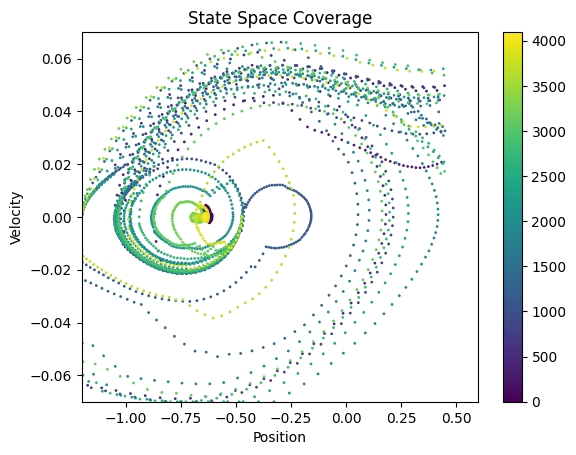

In [3]:
experiment = CatsExperiment(
    cfg=cfg,
    collection_steps=COLLECTION_STEPS,
    device=DEVICE,
    enable_policy_sampling=True,
    teleport_strategy=None,
    environment_action_noise=0,
    seed=0
)
experiment.run()

print(experiment.log['total_intrinsic_reward'])
print(entropy_memory(experiment.memory))
visualise_memory(experiment)

# Bootstrapping Intrinsic Motivation

Does it help?

In [ ]:
N = 10

baseline_statistics = {
    'total_intrinsic_reward': [],
    'newly_collected_intrinsic_reward': [],
    'entropy': []
}
bootstrapping_statistics = copy.deepcopy(baseline_statistics)

# Baseline
for seed in range(0, N):
    experiment = CatsExperiment(
        cfg=cfg,
        collection_steps=COLLECTION_STEPS,
        seed=seed,
        device=DEVICE,
        enable_policy_sampling=False
    )
    experiment.run()
    for k,v in experiment.log.items():
        baseline_statistics[k].append(v)
    baseline_statistics['entropy'].append(entropy_memory(experiment.memory))

for seed in range(0, N):
    experiment = CatsExperiment(
        cfg=cfg,
        collection_steps=COLLECTION_STEPS,
        seed=seed,
        device=DEVICE,
        enable_policy_sampling=True
    )
    experiment.run()
    for k,v in experiment.log.items():
        bootstrapping_statistics[k].append(v)
    bootstrapping_statistics['entropy'].append(entropy_memory(experiment.memory))


In [ ]:
print("Baseline")
print(f"Total Intrinsic Reward: {sum(baseline_statistics['total_intrinsic_reward'])/N}")
print(f"Collected Intrinsic Reward: {sum(baseline_statistics['newly_collected_intrinsic_reward'])/N}")
print(f"Entropy: {sum(baseline_statistics['entropy'])/N}")
print("Bootstrapped")
print(f"Total Intrinsic Reward: {sum(bootstrapping_statistics['total_intrinsic_reward'])/N}")
print(f"Collected Intrinsic Reward: {sum(bootstrapping_statistics['newly_collected_intrinsic_reward'])/N}")
print(f"Entropy: {sum(bootstrapping_statistics['entropy'])/N}")

# Impact of Aleatoric Uncertainty

In [ ]:
N = 10 # Number of repeats
COLLECTION_STEPS = 4096
SEED = 0

baseline_statistics = [] 

for uncertainty in np.linspace(0, 0.5, 11):
    statistics = {}
    statistics["entropy"] = []
    statistics["log"] = []
    
    experiment = CatsExperiment(
        cfg=cfg,
        collection_steps=COLLECTION_STEPS,
        seed=SEED,
        device=DEVICE,
        enable_policy_sampling=False,
        environment_action_noise=uncertainty
    )
    experiment.run()
    statistics["entropy"].append(entropy_memory(experiment.memory))
    statistics["log"].append(experiment.log)

    baseline_statistics.append(statistics)

In [ ]:
visualise_memory(experiment.env, (experiment.memory, "test"))

# When to reset

In [ ]:
# Good attempt, but doesn't reall work

experiment_cfg = copy.deepcopy(cfg)
experiment_cfg.noise.scale = [0.1, 0.01]
experiment = CatsExperiment(
    cfg=experiment_cfg,
    collection_steps=COLLECTION_STEPS,
    max_episode_steps=math.inf,
    device=DEVICE,
    enable_policy_sampling=True,
    teleport_strategy=None,
    reset_as_an_action=True,
    environment_action_noise=0,
    seed=0
)
experiment.run()

#print(experiment.log['total_intrinsic_reward'])
#print(entropy_memory(experiment.memory))
visualise_memory(experiment)

# Old Code (To be moved)

In [ ]:
# Some deprecated code


# # Learn To Truncate
# 
# class CATS_Truncate(Experiment):
# 
#     def __init__(self,
#                  cfg,
#                  max_episode_steps: Optional[int] = None,
#                  death_is_not_the_end: bool = True,
#                  fixed_reset: bool = False,
#                  storage_size: float = 100,
#                  epsilon: float = 0.1):
#         super().__init__(cfg, max_episode_steps, death_is_not_the_end, fixed_reset)
# 
#         self.storage_size = storage_size
#         # Recently explored trajectory
#         self.trajectory = []
# 
#         # Current time step
#         self.trajectory_index = 0
#         self.trajectory_counter = 0
#         # Target Timestep
#         self.teleport_index = 0
#         # Reset epsilon
#         self.epsilon = epsilon
#         
#         # Environment deepcopies
#         self.state = None
#         self.quicksaves = []
# 
#         # RNG
#         self.np_rng = np.random.default_rng(self.cfg.seed)
# 
#         self.log["teleport_targets"] = []
#         self.log["teleport_targets_observations"] = []
#         self.log["latest_trajectory"] = []
# 
#     def _build_env(self, max_episode_steps=None):
#         super()._build_env(max_episode_steps)
# 
#         # Learn to Truncate
#         self.env = self.env.env
# 
#     def _teleport_selection(self, V):
#         #V = V**2
#             # Argmax
#         teleport_index = torch.argmax(V).item()
#             # Probability Matching
#         #p = V / V.sum()
#         # pt = self.np_rng.random()
#         # pc = 0
#         # for i, pi in enumerate(p):
#         #     pc += pi
#         #     if pc >= pt or i == len(p) - 1:
#         #         teleport_index = i
#         #         break
#         #     # TODO: Upper Confidence bound
#         return teleport_index
# 
#     def _reset(self, V):
#         if self.fixed_reset:
#             return
#             # Epsilon Greedy Reset
#         #if torch.rand(1) < epsilon:
#         #    obs, infos = collector.env.reset()
#         #    resets[0] = collector.env
#         #    trajectory[0] = torch.tensor(obs, device=DEVICE)
#         #    teleport_index = 0
#             # Reset Buffer
#         reset_buffer = []
#         reset_buffer_obs = []
#         for i in range(10):
#             obs, info = self.collector.env.reset(seed=int(self.np_rng.integers(65536)))
#             reset_buffer.append(copy.deepcopy(self.collector.env))
#             reset_buffer_obs.append(obs)
#         reset_buffer_obs = torch.tensor(np.array(reset_buffer_obs, dtype=np.float32), device=DEVICE)
#         V_r = self.V(reset_buffer_obs)
#         best_reset_index = torch.argmax(V_r).item()
#         #if self.np_rng.random() < self.epsilon or V_r[best_reset_index] >= V[self.teleport_index]:
#         if V_r[best_reset_index] >= V[self.teleport_index]:
#             self.collector.env = reset_buffer[best_reset_index]
#             self.quicksaves[0] = self.collector.env
#             self.trajectory[0] = reset_buffer_obs[best_reset_index]
#             self.teleport_index = 0
# 
#     def run(self):
#         if self.fixed_reset:
#             self.collector.env.reset(seed=self.cfg.seed)
# 
#         early_start_transitions = self.collector.early_start(cfg.train.initial_collection_size)
#         for t in early_start_transitions:
#             self._update_memory(*t)
# 
#         batch, aux = self.memory.sample(self.cfg.train.initial_collection_size)
#         self.intrinsic.initialise(Transition(*batch), aux)
# 
#         # Main Loop
#         if self.fixed_reset:
#             self.collector.env.reset(seed=self.cfg.seed)
#         else:
#             self.collector.env.reset()
# 
#         self.state = copy.deepcopy(self.collector.env)
#         newly_collected_intrinsic_reward = 0
#         for step in tqdm(range(1, cfg.train.total_frames+1)):
#             obs, action, reward, n_obs, terminated, _ = self.collector.collect(n=1)[-1]
# 
#             newly_collected_intrinsic_reward += self.intrinsic.reward(Transition(
#                 torch.tensor(obs, device=DEVICE).unsqueeze(0),
#                 torch.tensor(action, device=DEVICE).unsqueeze(0),
#                 torch.tensor(reward, device=DEVICE).unsqueeze(0),
#                 torch.tensor(n_obs, device=DEVICE).unsqueeze(0),
#                 torch.tensor(terminated, device=DEVICE).unsqueeze(0)
#             ))[2].item()
# 
#             if self.trajectory_counter == self.storage_size - 1:
#                 truncated = True
#             else:
#                 truncated = False
#             # Time Limit Normalisation
#             # obs, n_obs = copy.deepcopy(obs), copy.deepcopy(n_obs)
#             # obs[-1] = obs[-1] / self.env.spec.max_episode_steps
#             # n_obs[-1] = n_obs[-1] / self.env.spec.max_episode_steps
# 
#             # Update trajectory
#             self.quicksaves.append(self.state)
#             self.trajectory.append(obs)
#             self.state = copy.deepcopy(self.collector.env)
#             self.trajectory_index += 1
#             self.trajectory_counter += 1
# 
#             # Manage Teleportation
#             if truncated or terminated:
#                 # Calculate Value
#                 V = self.V(torch.tensor(self.trajectory,device=DEVICE))
#                 # Teleportation Selection
#                 with torch.no_grad():
#                     self.teleport_index = self._teleport_selection(V)
#                 # Resets
#                 self._reset(V)
# 
#                 # Teleport
#                 self.collector.env = self.quicksaves[self.teleport_index]
#                 self.collector.obs = self.trajectory[self.teleport_index]
#                 self.collector.env.np_random = np.random.default_rng(self.np_rng.integers(65536))
# 
#                 self.trajectory_index = self.teleport_index
#                 self.trajectory_counter = 0
#                 self.trajectory = self.trajectory[:self.teleport_index+1]
#                 self.quicksaves = self.quicksaves[:self.teleport_index+1]
#                 self.state = copy.deepcopy(self.collector.env)
# 
#                 # Log
#                 self.log["teleport_targets"].append(self.teleport_index)
#                 self.log["teleport_targets_observations"].append(self.collector.obs)
#                 self.log["latest_trajectory"] = self.trajectory
# 
#             # Update Memory
#             self._update_memory(obs, action, reward, n_obs, terminated, truncated)
#             
#             # Remaining RL Update
#             batch, aux = self.memory.sample(self.cfg.train.minibatch_size)
#             batch = Transition(*batch)
#             if self.death_is_not_the_end:
#                 batch = Transition(batch.s_0, batch.a, batch.r, batch.s_1, torch.zeros(batch.d.shape, device=DEVICE).bool())
# 
# 
#             r_t, r_e, r_i = self.intrinsic.reward(batch)
#             self.intrinsic.update(batch, aux, step=step)
# 
#             batch = Transition(batch.s_0, batch.a, r_i, batch.s_1, batch.d)
#             self.algorithm.update(batch, aux, step=step)
# 
#             # Log
#             self.log["total_intrinsic_reward"] += r_i.mean().item()
# 
#         print(newly_collected_intrinsic_reward)
        